In [12]:
# %reset -f
%config Completer.use_jedi = True
# %matplotlib widget
from scipy.stats import rankdata
from sklearn.preprocessing import normalize
import graphistry
graphistry.register(api=3, username='dcolinmorgan', password='f5UwthGEF@F@xnP')
import sklearn.utils as sku
import plotly.graph_objects as go
import plotly.express as px
import chart_studio.plotly as py
# import chart_studio
# chart_studio.tools.set_credentials_file(username='dcolinmorgan', api_key='9FS3nO6nWYFq5zT6BRHD')
import plotly
import scipy
import warnings
warnings.filterwarnings('ignore')

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os,glob,sys,importlib,pickle,tqdm
from itertools import combinations#,scipy,coolbox,pybedtools,
# from scipy.stats import linregress
# from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from IPython.display import Image
import pandas as pd
import seaborn as sns
from scipy import stats
import networkx as nx
# import pyvis
# from pyvis.network import Network
import networkit as nk
# import biosppy
# from sklearn import metrics

os.chdir('/home/dcmorgan')
os.getcwd()

'/home/dcmorgan'

# bioinfo > net

In [ ]:
R0396MWT=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t',usecols=[0,1])
R0396MWT=R0396MWT[R0396MWT['R0003-CPK-DNA_Abundance-RPKs']!=0]

In [ ]:
# R0396MWT['gene']=R0396MWT['# Gene Family'].str.split('|').str[0].str.split('_').str[1].tolist()
# R0396MWT['spec']=R0396MWT['# Gene Family'].str.split('|').str[1].tolist()

# R0396MWT=R0396MWT[['spec','gene']]
# R0396MWT.spec=R0396MWT.spec.astype('str')


R0396MWTa=R0396MWT.loc[np.random.choice(R0396MWT.index, 5000, replace=False)]

In [ ]:
[len(np.unique(R0396MWTa['spec'])),
len(np.unique(R0396MWTa['gene'].astype('str')))]

In [ ]:
G=nx.from_pandas_edgelist(R0396MWTa, 'gene', 'spec', edge_attr=None, create_using=None)
# G = nx.Graph(source=['gene'],target=R0396MWT['spec'])

In [ ]:
from networkx.algorithms import bipartite
# G = nx.path_graph(4)
print(bipartite.is_bipartite(G))
# is_bipartite(G)

In [ ]:
g = nk.generators.HyperbolicGenerator(1e5).generate()
communities = nk.community.detectCommunities(g, inspect=True)

In [ ]:
%%bash
pat=R0396-MWT
awk '($3>90)' run/gcn/pat/"$pat"_proteins_o2 > "$pat"_nko
cut -f2 "$pat"_nko |cut -d "|" -f 1|cut -d "_" -f 2 > "$pat"_tmpA
cut -f2 "$pat"_nko |cut -d "|" -f 2 > "$pat"_tmpB
cut -f3 "$pat"_nko >"$pat"_tmpC
pr -mt -s, "$pat"_tmpB "$pat"_tmpA "$pat"_tmpC >"$pat"_nk
# awk '($3>90)' "$pat"_tmpD >"$pat"_nk
rm *tmp*

In [ ]:
reader = nk.graphio.EdgeListReader(',',1,'#',directed=False,continuous=False)
G = reader.read('R0396-MWT_nk')
map = reader.getNodeMap()


In [ ]:
dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [ ]:
nk.profiling.Profile.create(G).output('pdf','tmp')

In [ ]:
plmCommunities = nk.community.detectCommunities(G, algo=nk.community.PLM(G, True))

In [ ]:
print("{0} elements assigned to {1} subsets".format(plmCommunities.numberOfElements(),
plmCommunities.numberOfSubsets()))
nk.community.writeCommunities(plmCommunities, "tmp/communtiesPLM.partition")

In [ ]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [ ]:
coreDec = nk.centrality.CoreDecomposition(g)
coreDec.run()
nk.viztasks.drawGraph(g, node_size=[(k**2)*20 for k in coreDec.scores()])
plt.show()

# pheno

In [14]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [15]:
uni_bact=primary[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]
uni_bact=uni_bact.rename(columns={"Hypertension Category by 24h BP w/o considering antihypertensive med": "HT"})
# uni_bact.to_csv('data/gcn/uni_bact.txt',sep='\t')

# build networks

In [ ]:
# %%bash
# humann_join_tables -i /groups/cgsd/gordonq/LeungWK_Metagenomics_SS-190611-01a/humann3 -o arg_subset_genefamilies.tsv --file_name genefamilies
# humann_renorm_table -i arg_subset_genefamilies.tsv -o arg_subset_genefamilies-cpm.tsv --units cpm

In [ ]:
# relab=pd.read_csv('../../groups/cgsd/gordonq/all_hypertension/342_K2_contigsum.csv')
# relab[['p', 'c','o','f','g','s']]=pd.DataFrame(relab["Unnamed: 0"].str.split(';', expand=True).values,
#              columns=['p', 'c','o','f','g','s'])
# del relab["Unnamed: 0"]
# relgene=pd.read_csv('/groups/cgsd/gordonq/LauG_Metagenomics_CPOS-200710-CJX-3455a/50_genefamilies.tsv',sep='\t')
# relgene=pd.read_csv('50_genefamilies-cpm.tsv')
# relgene=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t',nrows=100)
relgene=pd.read_csv('',sep='\t')
relgene['gene']=relgene['# Gene Family'].str.split('|').str[0]
relgene=relgene[relgene['gene']!='UniRef90_unknown']
relgene=relgene[relgene['gene']!='UNMAPPED']
relgene.index=relgene['# Gene Family']
del relgene['gene'], relgene['# Gene Family']
# relgene=relgene/relgene.sum(axis=0)

# relgene=relgene/relgene.sum(axis=0)
relgene['gen']=relgene.index.str.split('|').str[1].str.split('.').str[0].tolist()
relgene['spec']=relgene.index.str.split('.').str[1]#.str.split('.').str[0].tolist()
relgene['spec'].replace('_',' ')
relgene.index=relgene.index.str.split('|').str[0]
relgene=relgene.dropna()
# del relgene['# Gene Family']


In [ ]:
cc=relgene.groupby(['# Gene Family','spec']).sum()
# dd=relgene.groupby(['# Gene Family','gen']).sum()
cc=cc.reset_index()
# dd=dd.reset_index()
cc=cc.rename(columns={'# Gene Family':'gene'})#,'spec':0,'gene':1})

# dd=cc[['gene','spec',net]]
# dd=dd[dd[net]!=0]

check instrucitons [from here](https://stackoverflow.com/questions/23975773/how-to-compare-directed-graphs-in-networkx#54677502)
and [here](https://stackoverflow.com/questions/18261587/python-networkx-remove-nodes-and-edges-with-some-condition)

In [ ]:
relgene=pd.read_csv('data/gcn/relgene_other.txt',sep='\t')

In [ ]:
from networkx.algorithms import bipartite
ff=[]
C=[]
for i,net in enumerate(relgene.columns[1:-2]):
    pd.read_csv()
    dd=cc[['spec','gene',net]]
    dd=dd[dd[net]!=0]
    ee=nx.from_pandas_edgelist(dd,source='spec',target='gene')
    remove = [node for node,degree in dict(ee.degree()).items() if degree <10]
    ee.remove_nodes_from(remove)
    ff.append(ee)
    
    B = nx.Graph()
    B.add_nodes_from(dd['spec'], bipartite=0)
    B.add_nodes_from(dd['gene'], bipartite=1)
    B.add_edges_from(tuple(dd[['spec','gene']].itertuples(index=False, name=None)))
    remove = [node for node,degree in dict(B.degree()).items() if degree <10]
    B.remove_nodes_from(remove)
    C.append(B)

with open('data/gcn/NX_all_hypert.pkl', 'wb') as f:
    pickle.dump(ff, f)
with open('data/gcn/BX_all_hypert.pkl', 'wb') as f:
    pickle.dump(C, f)

In [ ]:
graphs = load_list_of_dicts('data/gcn/BX_all100_hypert.pkl')
len(graphs[0].edges())
# B=graphs[3]
# remove = [node for node,degree in dict(B.degree()).items() if degree <2]
# B.remove_nodes_from(remove)
# len(B.edges)

In [ ]:
measur=eval('nx.degree_centrality')
tmp=plt.hist(measur(graphs[1]),bins=20)
tmp=plt.hist(measur(graphs[0]),bins=20,alpha=.5)

In [ ]:
HT50=uni_bact[uni_bact.index.isin(relgene.columns[:-2].str.split('-').str[0])]
HT50['index']=np.arange(len(HT50))
S = [nx.clustering(graphs[i]) for i in HT50[HT50['HT']==0]['index'].values]
T = [nx.clustering(graphs[i]) for i in HT50[HT50['HT']!=0]['index'].values]

In [ ]:
non=pd.DataFrame(S).melt()
non['type']='NoHT'
non.dropna(inplace=True)
non=non[non.value!=0]
non=non[~non['variable'].str.contains('UniRef90')]
non.value=non.value/np.sum(non.value)
yes=pd.DataFrame(T).melt()
yes['type']='HT'
yes.dropna(inplace=True)
yes=yes[yes.value!=0]
yes=yes[~yes['variable'].str.contains('UniRef90')]
yes.value=yes.value/np.sum(yes.value)
df=non.append(yes)
# df=df.dropna()
df['gen']=df.variable.str.split('_').str[2]

In [ ]:
[sum(non.value),sum(yes.value)]

In [ ]:
tmp=plt.hist(non.value,log=True,bins=100)
tmp=plt.hist(yes.value,log=True,bins=100,alpha=.5)

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df[df['type']=='HT'], row="gen", hue="gen", aspect=20, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig("data/gcn/degree_centrality_HT.png",dpi=300,bbox_inches = "tight")


In [ ]:
relgene=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t')

relgene['gene']=relgene['# Gene Family'].str.split('|').str[0]
relgene=relgene[relgene['gene']!='UniRef90_unknown']
relgene=relgene[relgene['gene']!='UNMAPPED']
relgene.index=relgene['# Gene Family']
del relgene['gene'], relgene['# Gene Family']
# relgene=relgene/relgene.sum(axis=0)
relgene=relgene/relgene.sum(axis=0)
relgene['gen']=relgene.index.str.split('|').str[1].str.split('.').str[0].tolist()
relgene['spec']=relgene.index.str.split('.').str[1]#.str.split('.').str[0].tolist()
relgene['spec'].replace('_',' ')
relgene.index=relgene.index.str.split('|').str[0]
relgene=relgene.dropna()


cc=relgene.groupby(['# Gene Family','spec']).sum()
# dd=relgene.groupby(['# Gene Family','gen']).sum()
cc=cc.reset_index()
# dd=dd.reset_index()
cc=cc.rename(columns={'# Gene Family':'gene'})#,'spec':0,'gene':1})


primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
uni_bact=primary[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]
uni_bact=uni_bact.rename(columns={"Hypertension Category by 24h BP w/o considering antihypertensive med": "HT"})


# analyze nets

In [239]:
patt='all'
sys.path.insert(1, './run/gcn/')
import gcn_func
importlib.reload(sys.modules['gcn_func'])
from gcn_func import bip, load_list_of_dicts, meas, time_bar,proc_dat,rev_tbar,group_time_plot,time_order_net,build_gcn#plotRidge,LayeredNetworkGraph,plot_sankey

# relgene=pd.read_csv('data/gcn/relgene_all.txt',sep='\t')
# graphs = load_list_of_dicts('data/gcn/BX_'+patt+'_HT.pkl')
# HTXX=uni_bact[uni_bact.index.isin(relgene.columns[1:-2].str.split('-').str[0])]
# HTXX['index']=np.arange(len(HTXX))


In [255]:
build_gcn('arg_subset_genefamilies-cpm.tsv','ARG')

TypeError: read_csv() missing 1 required positional argument: 'filepath_or_buffer'

In [169]:
# for i,net in tqdm.tqdm(enumerate(BX_graphs)):
for i,net in tqdm(enumerate(HTXX[HTXX['HT']!=5]['index'].values)):
  cc=nx.convert_matrix.to_pandas_edgelist(graphs[i])
  # cc['weight']=np.random.randn(len(cc))
  rrr=str(HTXX[HTXX['index']==i]['Age'].item())+'_'+str(HTXX[HTXX['index']==i]['HT'].item())#+'_'+str(HTXX[HTXX['index']==i]['sex'].item())
  cc.rename(columns={cc.columns[2]:rrr},inplace=True)
  if i==0:
    dd=cc
  else:
    dd=dd.merge(cc,on=['source','target'],how='outer')
# dd.dropna(how='any')

286it [02:35,  1.84it/s]


In [170]:
dd.set_index(['source', 'target'], inplace=True) #>> run only first time editing dd
# dd = dd/np.max(dd,axis=0)
# dd=dd/np.sum(dd,axis=0) ###tried to do things strangely
### dd=np.argsort(dd)
noHT=dd.filter(regex='_0_').dropna(how='all')
HT1=dd.filter(regex='_1_')#.dropna(how='all')
HT2=dd.filter(regex='_2_')#.dropna(how='all')
HT=HT1.merge(HT2,right_index=True,left_index=True).dropna(how='all')
# [noHT.shape,HT1.shape,HT2.shape]
[noHT.shape,HT.shape]

[(138518, 98), (137485, 148)]

## case v control nets

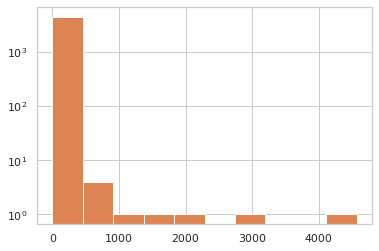

In [109]:
ccc=pd.DataFrame(noHT.sum(axis=1)).reset_index()
g=nx.from_pandas_edgelist(ccc,source='source',target='target',edge_attr=0)
C = nx.Graph()
C.add_nodes_from(ccc['source'], bipartite=0)
C.add_nodes_from(ccc['target'], bipartite=1)
C.add_weighted_edges_from(tuple(ccc[['source','target',0]].itertuples(index=False, name=None)))

ddd=pd.DataFrame(HT.sum(axis=1)).reset_index()
g=nx.from_pandas_edgelist(ddd,source='source',target='target',edge_attr=0)
B = nx.Graph()
B.add_nodes_from(ccc['source'], bipartite=0)
B.add_nodes_from(ccc['target'], bipartite=1)
B.add_weighted_edges_from(tuple(ccc[['source','target',0]].itertuples(index=False, name=None)))

pd.DataFrame(nx.degree_histogram(B))
pd.DataFrame(nx.degree_histogram(C))

tmp=plt.hist(nx.degree_histogram(C),log=True,bins=10)

tmp=plt.hist(nx.degree_histogram(B),log=True,bins=10)

In [17]:
ccc=pd.DataFrame(noHT.sum(axis=1)).reset_index()
# ccc=ccc[ccc[0]>10**-2].dropna()#percentage cutoff
ccc=ccc[ccc[0]>10].dropna()
# g=nx.from_pandas_edgelist(ccc,source='source',target='target',edge_attr=0)
C = nx.Graph()
C.add_nodes_from(ccc['source'], bipartite=0)
C.add_nodes_from(ccc['target'], bipartite=1)
C.add_weighted_edges_from(tuple(ccc[['source','target',0]].itertuples(index=False, name=None)))

ddd=pd.DataFrame(HT.sum(axis=1)).reset_index()
# ddd=ddd[ddd[0]>10**-2].dropna()
ddd=ddd[ddd[0]>10].dropna()
# g=nx.from_pandas_edgelist(ddd,source='source',target='target',edge_attr=0)
B = nx.Graph()
B.add_nodes_from(ddd['source'], bipartite=0)
B.add_nodes_from(ddd['target'], bipartite=1)
B.add_weighted_edges_from(tuple(ddd[['source','target',0]].itertuples(index=False, name=None)))


In [18]:
g = graphistry.edges(ddd, 'source', 'target','value')
g.plot()

In [19]:
g = graphistry.edges(ccc, 'source', 'target','value')
g.plot()

## bin & time steps

In [253]:
# dd.set_index(['source', 'target'], inplace=True)
# dd=dd/np.sum(dd,axis=0)
### dd=np.argsort(dd)
noHT=dd.filter(regex='_0_').dropna(how='all')
HT1=dd.filter(regex='_1_')#.dropna(how='all')
HT2=dd.filter(regex='_2_')#.dropna(how='all')
HT=HT1.merge(HT2,right_index=True,left_index=True).dropna(how='all')
# [noHT.shape,HT1.shape,HT2.shape]
[noHT.shape,HT.shape]

[(138518, 98), (137485, 148)]

In [241]:
BBgrow,BBdie=time_order_net(noHT,HT,10**-6,['source','target'],6,1,'mean')
[BBgrow.shape,BBdie.shape]

[(215, 6), (97, 6)]

In [254]:
BBgrow,BBdie=time_order_net(noHT,HT,10**-6,['source','target'],6,1,'median')
[BBgrow.shape,BBdie.shape]

[(215, 6), (97, 6)]

## networkx stuff

In [37]:
g=nx.from_pandas_edgelist(noHT[noHT[0]>10**-6].dropna(),source='source',target='target',edge_attr=0)
h=nx.from_pandas_edgelist(noHT[noHT[1]>10**-6].dropna(),source='source',target='target',edge_attr=1)
i=nx.from_pandas_edgelist(noHT[noHT[2]>10**-6].dropna(),source='source',target='target',edge_attr=2)
j=nx.from_pandas_edgelist(noHT[noHT[3]>10**-6].dropna(),source='source',target='target',edge_attr=3)
k=nx.from_pandas_edgelist(noHT[noHT[4]>10**-6].dropna(),source='source',target='target',edge_attr=4)
l=nx.from_pandas_edgelist(noHT[noHT[5]>10**-6].dropna(),source='source',target='target',edge_attr=5)
m=nx.from_pandas_edgelist(noHT[noHT[6]>10**-6].dropna(),source='source',target='target',edge_attr=6)

gg=nx.from_pandas_edgelist(HT[HT[0]>10**-6].dropna(),source='source',target='target',edge_attr=0)
hh=nx.from_pandas_edgelist(HT[HT[1]>10**-6].dropna(),source='source',target='target',edge_attr=1)
ii=nx.from_pandas_edgelist(HT[HT[2]>10**-6].dropna(),source='source',target='target',edge_attr=2)
jj=nx.from_pandas_edgelist(HT[HT[3]>10**-6].dropna(),source='source',target='target',edge_attr=3)
kk=nx.from_pandas_edgelist(HT[HT[4]>10**-6].dropna(),source='source',target='target',edge_attr=4)
ll=nx.from_pandas_edgelist(HT[HT[5]>10**-6].dropna(),source='source',target='target',edge_attr=5)
mm=nx.from_pandas_edgelist(HT[HT[6]>10**-6].dropna(),source='source',target='target',edge_attr=6)

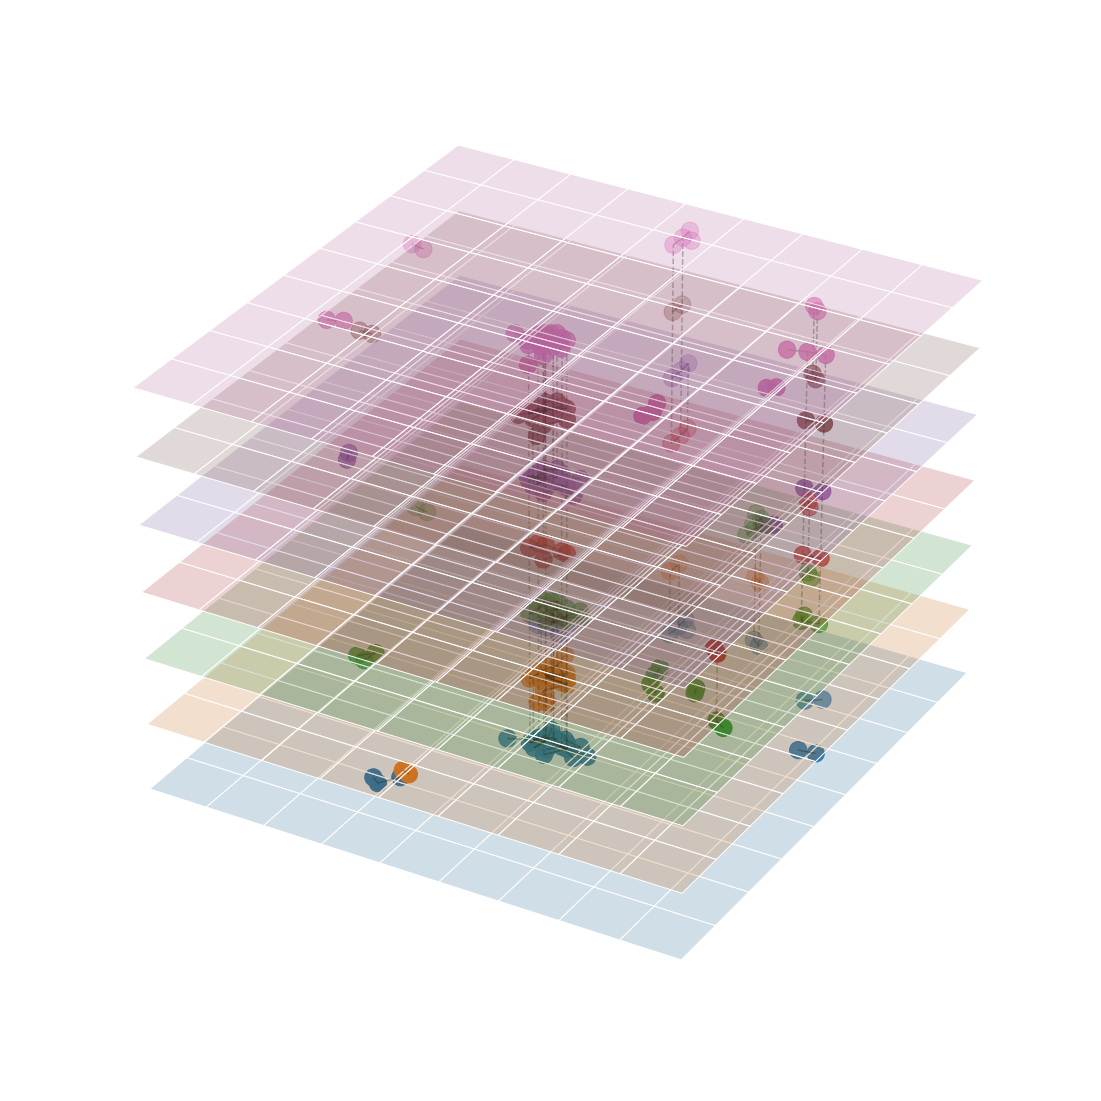

In [131]:
fig=plt.figure(figsize=(5,15))
ax = fig.add_subplot(projection='3d')
LayeredNetworkGraph([g, h, i,j,k,l,m], ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
# ax.figsize(5,15)
# plt.show()
fig.set_size_inches(20, 20)
fig.savefig('noHT.png', dpi=100)

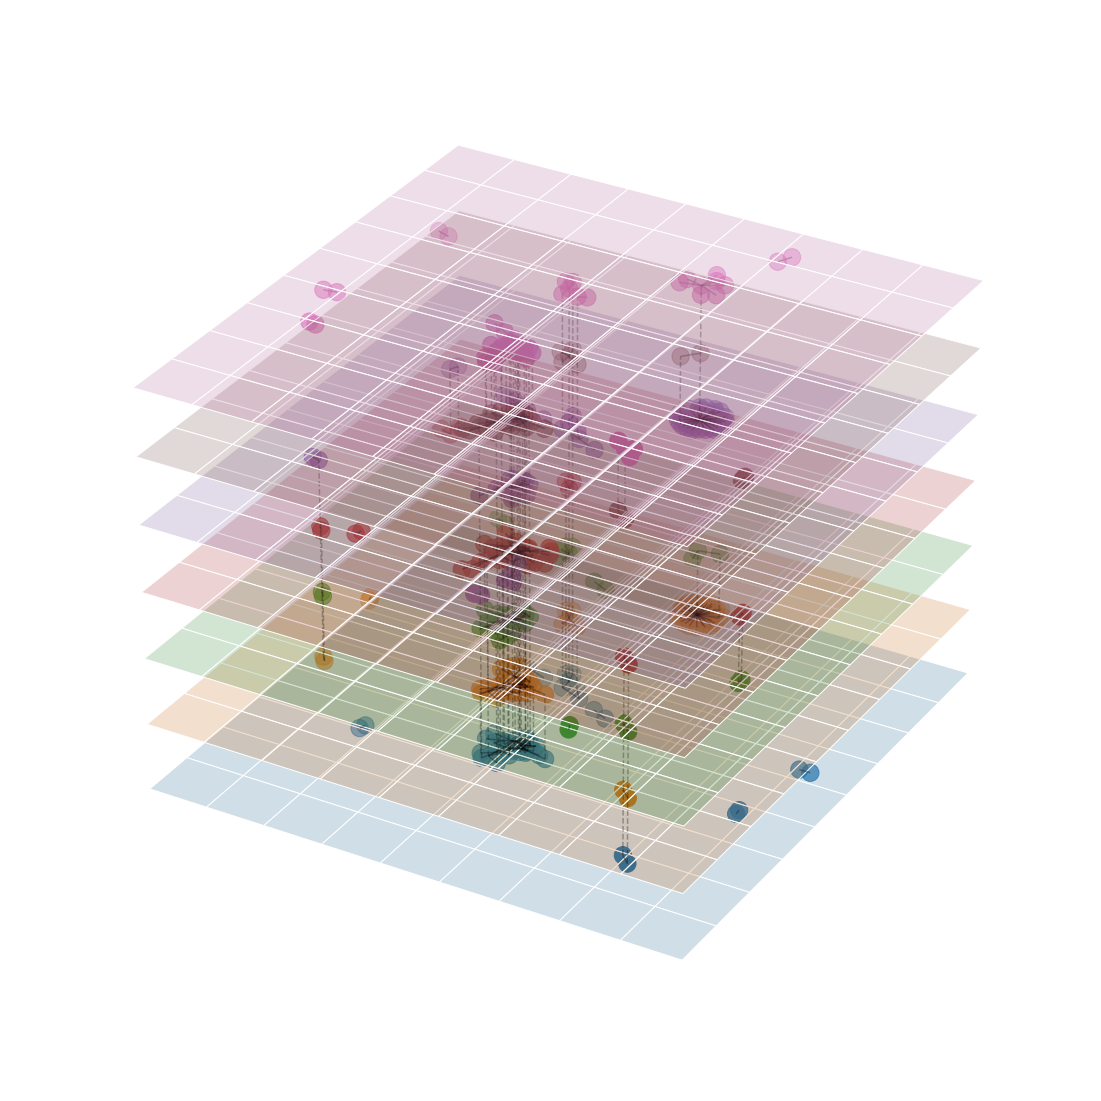

In [133]:
fig=plt.figure(figsize=(5,15))
ax = fig.add_subplot(projection='3d')
LayeredNetworkGraph([g, h, i,j,k,l,m], ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
# ax.figsize(5,15)
# plt.show()
fig.set_size_inches(20, 20)
fig.savefig('HT.png', dpi=100)

## 7 groups histograms

In [147]:
cc

,source,target,0,1,2,3,4,5,6,all
0,s__Bacteroides_fragilis,UniRef90_A0A015P063,0.161968,3.428513,0.024364,0.144229,0.027537,0.206218,0.763379,1.532787
1,s__Bacteroides_fragilis,UniRef90_A0A015QIN6,120.222164,153.669494,NaN,135.257977,94.578504,NaN,6.556933,3318.079568
2,s__Bacteroides_fragilis,UniRef90_A0A015TZH5,10.426517,0.182845,NaN,NaN,NaN,0.141773,1.455621,24.544465
3,s__Bacteroides_fragilis,UniRef90_A0A015U8D5,0.144928,1.698024,0.003901,0.199911,0.001951,3.433236,0.180333,1.697282
4,s__Bacteroides_fragilis,UniRef90_A0A015U8H2,10.334522,30.518451,6.087866,5.906543,0.744355,431.038267,14.941701,25245.799461
...,...,...,...,...,...,...,...,...,...,...
85574,s__Bacteroides_ovatus,UniRef90_R7HM42,NaN,NaN,NaN,NaN,2.906666,NaN,0.130913,3.852402
85578,s__Bacteroides_uniformis,UniRef90_R7HM42,NaN,NaN,NaN,NaN,0.637070,NaN,0.105038,0.141529
85581,s__Prevotella_copri,UniRef90_R7HM42,NaN,NaN,NaN,NaN,1.499697,NaN,86.535300,3615.526898
85585,s__Prevotella_stercorea,UniRef90_R7HM42,NaN,NaN,NaN,NaN,9.818033,NaN,189.554858,16152.663217


<AxesSubplot:xlabel='value', ylabel='Density'>

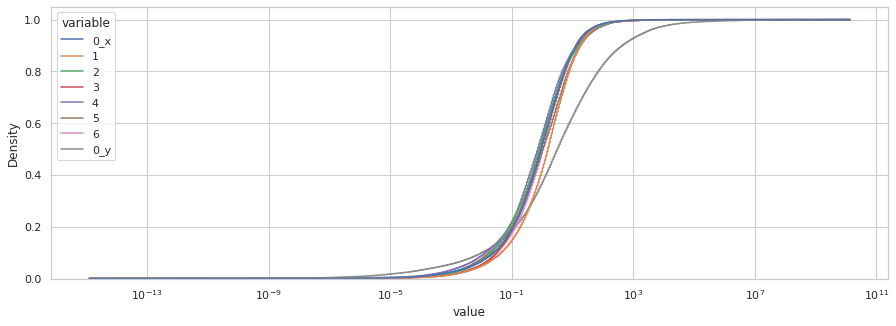

In [151]:
cc=HT.merge(pd.DataFrame(aa),right_index=True,left_index=True)
# cc.rename(columns={'0_x':'0','0_y':'all'},inplace=True)
cc=cc.melt(['source','target'])
plt.figure(figsize=(15,5))
sns.histplot(data=cc, x="value", hue="variable", log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False)
    

<AxesSubplot:xlabel='value', ylabel='Count'>

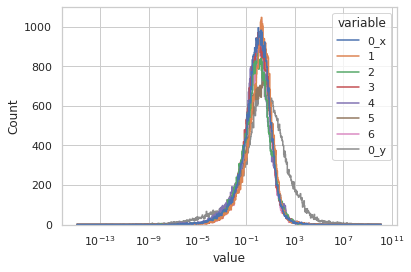

In [149]:
sns.histplot(data=cc, x="value", log_scale=True, element="step", fill=False,hue='variable')


<AxesSubplot:xlabel='value', ylabel='Density'>

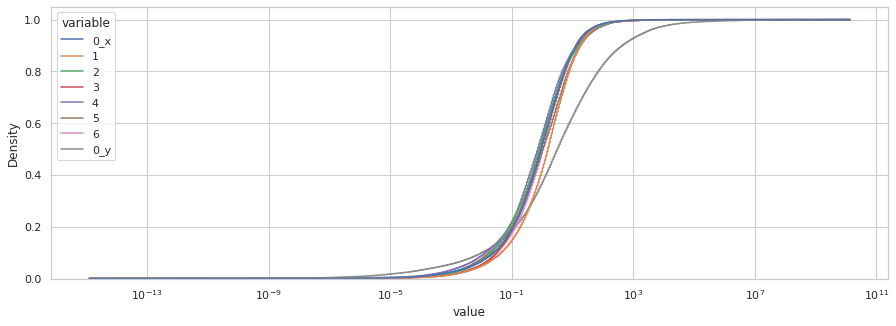

In [156]:
dd=noHT.merge(pd.DataFrame(aa),right_index=True,left_index=True)
# cc.rename(columns={'0_x':'0','0_y':'all'},inplace=True)
dd=dd.melt(['source','target'])
plt.figure(figsize=(15,5))
sns.histplot(
    data=cc, x="value", hue="variable",
    # hue_order=["Radial Velocity", "Transit"],
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

<AxesSubplot:xlabel='value', ylabel='Count'>

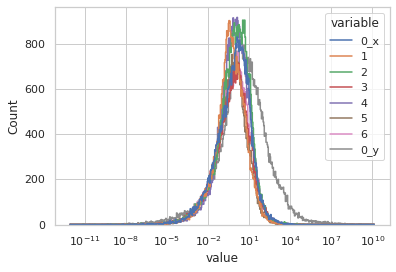

In [157]:
sns.histplot(data=dd, x="value", log_scale=True, element="step", fill=False,hue='variable')


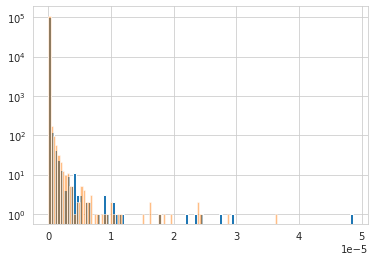

In [ ]:
# tmp=plt.hist(HT.melt().value.dropna(how='all'),bins=100,log=True)
tmp=plt.hist(bb.values,bins=100,log=True)
tmp=plt.hist(aa.values,bins=100,log=True,alpha=.5)


## time plot

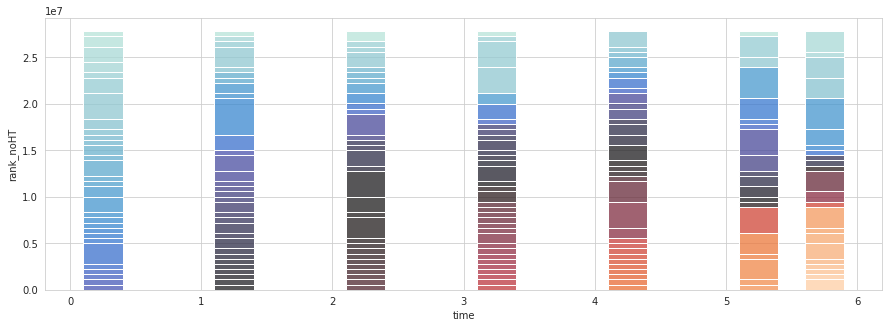

In [37]:
group_time_plot(noHT,7,10,'0')

In [142]:
jj['variable']=jj['variable'].astype('int')+2000
jj['variable'] = pd.to_datetime(jj['variable'], format='%Y')

In [143]:
# dd=(noHT-HT).dropna().melt()
# plt.figure(figsize=(15,5))
# sns.histplot(
#     data=dd, x="value", hue="variable",
#     # hue_order=["Radial Velocity", "Transit"],
#     log_scale=True, element="step", fill=False,
#     cumulative=True, stat="density", common_norm=False,
# )
jj=noHT.reset_index().melt(id_vars=['source','target'])

g = graphistry.edges(jj, 'source', 'target','value','variable')
g.plot()

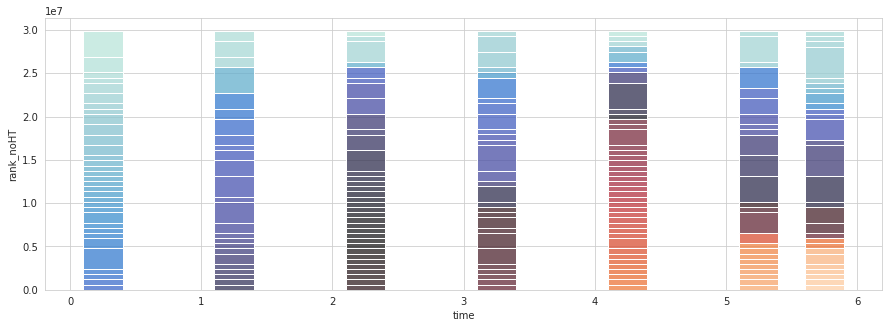

In [39]:
group_time_plot(HT,7,10,'0')

In [ ]:
# jj=jj.dropna(how='any')
# kk=kk.dropna(how='any')
# ll=jj.merge(kk,on=['source','target','time'],how='inner')
ll['vx']=rankdata(ll.value_x,method='min')
ll['vy']=rankdata(ll.value_y,method='min')
ll['diff']=ll['value_x']-ll['value_y']
ll['rank_diff']=ll['vx'].astype('int')-ll['vy'].astype('int')
ll['rank_diff']=np.abs(ll['rank_diff'])
ll.sort_values(by='rank_diff')
ll['species']=ll['source'].str.split('_').str[2]
# ll=ll[np.abs(ll['diff'])>1]
g = graphistry.edges(ll.dropna(how='any'), 'species', 'target','rank_diff')
g.plot()

## full time steps

In [ ]:
# dd = dd/np.max(dd,axis=0)
dd=dd/np.sum(dd,axis=0)
### dd=np.argsort(dd)
noHT=dd.filter(regex='_0_').dropna(how='all')
HT1=dd.filter(regex='_1_')#.dropna(how='all')
HT2=dd.filter(regex='_2_')#.dropna(how='all')
HT=HT1.merge(HT2,right_index=True,left_index=True).dropna(how='all')
# [noHT.shape,HT1.shape,HT2.shape]
[noHT.shape,HT.shape]

jj=noHT.reset_index().melt(id_vars=['source','target'])

noHT.columns=noHT.columns.str.split('_').str[0]
# noHT.columns=pd.qcut((noHT.columns).astype('int'), 7, labels=False)
noHT=noHT.groupby(by=noHT.columns, axis=1).mean()
noHT=noHT.dropna(how='all')

HT.columns=HT.columns.str.split('_').str[0]
# HT.columns=pd.qcut((HT.columns).astype('int'), 7, labels=False)
HT=HT.groupby(by=HT.columns, axis=1).mean()
HT=HT.dropna(how='all')

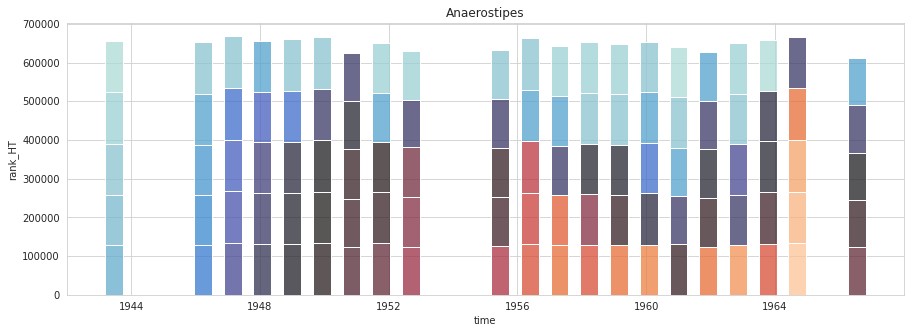

In [21]:
time_bar(jj,5,'rank','Anaerostipes')
# time_bar(jj,5,'value','all')
# time_bar(kk,5,'rank','all')
# time_bar(kk,5,'value','all')
# time_bar(ll,5,'rank_diff','all')
# time_bar(ll,5,'diff','all')

(array([1.34601e+05, 4.30000e+01, 5.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([9.73019437e-08, 1.34037499e-03, 2.68065267e-03, 4.02093036e-03,
        5.36120804e-03, 6.70148573e-03, 8.04176341e-03, 9.38204110e-03,
        1.07223188e-02, 1.20625965e-02, 1.34028742e-02]),
 <BarContainer object of 10 artists>)

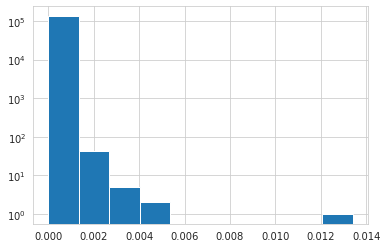

In [22]:
plt.hist(jj.value,log=True)

In [185]:
XX=10
labels,levels=pd.factorize(jj['target'])
jj['prot_id']=labels
jj['t']=jj['time'].astype('str').str.split('-').str[0]
labels,levels=pd.factorize(jj['t'])
jj['t']=labels
data=jj[['species','prot_id','time','t','value']]
df=data.copy()
grouped = data.groupby('prot_id')

def get_next_clus(x): return x['species'].shift(-1)

data["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)


# df = data[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)
jeff=pd.DataFrame(df.groupby(['species','t'])['value'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.loc[jeff['level_2']]

/tmp/ipykernel_12189/1710408779.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["next_clus"] = grouped.apply(


In [33]:
grouped = pd.DataFrame(jeffA.groupby(['species', 't'])['prot_id'].apply(list).groupby(level=0).apply(list))
jeff=grouped.explode('prot_id')
jeff.reset_index(inplace=True)

In [184]:
np.unique(data.species)

array(['Agathobaculum', 'Anaerostipes', 'Bacteroides', 'Bifidobacterium',
       'Blautia', 'Dorea', 'Escherichia', 'Eubacterium',
       'Faecalibacterium', 'Flavonifractor', 'Parabacteroides',
       'Roseburia', 'Ruminococcus', 'Ruthenibacterium', 'Streptococcus'],
      dtype=object)

In [34]:
jeff2=jeff[jeff['species']=='Agathobaculum'].explode('prot_id')
# jeff2['prot_id']#.str.split(',')
jeff3=pd.DataFrame(jeff2['prot_id'].to_numpy().reshape(int(len(jeff2)/21),21))
# jeff3.index='Agathobaculum'

(array([ 9.,  1.,  2.,  5.,  1.,  2.,  0.,  1.,  1.,  3., 12.,  1.,  0.,
         9., 19.,  1.,  5.,  4.,  0.,  2., 12.,  1.,  1., 14.,  0.,  3.,
         1.,  8.,  4.,  1.,  1.,  0., 17.,  2.,  1.,  1., 13.,  0.,  6.,
         6.,  1., 10.,  3.,  0.,  1.,  1.,  2., 10.,  8.,  4.]),
 array([ 0.  ,  0.84,  1.68,  2.52,  3.36,  4.2 ,  5.04,  5.88,  6.72,
         7.56,  8.4 ,  9.24, 10.08, 10.92, 11.76, 12.6 , 13.44, 14.28,
        15.12, 15.96, 16.8 , 17.64, 18.48, 19.32, 20.16, 21.  , 21.84,
        22.68, 23.52, 24.36, 25.2 , 26.04, 26.88, 27.72, 28.56, 29.4 ,
        30.24, 31.08, 31.92, 32.76, 33.6 , 34.44, 35.28, 36.12, 36.96,
        37.8 , 38.64, 39.48, 40.32, 41.16, 42.  ]),
 <BarContainer object of 50 artists>)

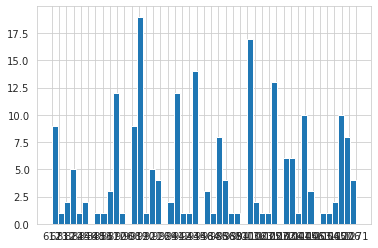

In [35]:
plt.hist((np.sort(jeff3.melt()['value'])).astype('str'),bins=50)#.value_counts())

<BarContainer object of 43 artists>

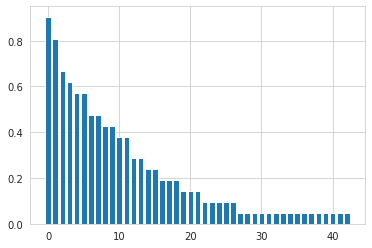

In [36]:
plt.bar(x=np.arange(len((np.unique(jeff3.melt()['value'])))),height=jeff3.melt()['value'].value_counts()/21)


## crazy time plot & stats
run from gcn_plot.py script

In [158]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

cw_lm=ols('value ~ C(variable)', data=cc[cc['variable']!='all']).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

                   sum_sq        df         F        PR(>F)
C(variable)  4.943047e-12       6.0  6.521825  6.751730e-07
Residual     5.327156e-08  421717.0       NaN           NaN


In [157]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

cw_lm=ols('value ~ C(variable)', data=dd[dd['variable']!='all']).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

                   sum_sq        df         F    PR(>F)
C(variable)  2.064443e-12       6.0  2.028492  0.058265
Residual     6.165503e-08  363488.0       NaN       NaN


## Sankey start
[from nicolasesnis github](https://gist.github.com/nicolasesnis/595d34c3c7dbca2b3419332304954433)

In [215]:
noHT=dd.filter(regex='_0_').dropna(how='all')

noHT.columns=noHT.columns.str.split('_').str[0]
# noHT.columns=pd.qcut((noHT.columns).astype('int'), 7, labels=False)
noHT=noHT.groupby(by=noHT.columns, axis=1).mean()
noHT.reset_index(inplace=True)
jj=noHT.melt(id_vars=['source','target'])
jj=jj.dropna(how='any')

jj.rename(columns={'variable':'t'},inplace=True)
# jj['t']=jj['variable'].astype('str').str.split('-').str[0]
labels,levels=pd.factorize(jj['t'])
jj['t']=labels
jj['species']=jj['source'].str.split('_').str[2]
data=jj[['species','target','t','value']]
df=data.copy()
# grouped = data.groupby('target')
XX=10
def get_next_clus(x): return x['species'].shift(-1)

data["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

# df = data[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)

jeff=pd.DataFrame(df.groupby(['species','t'])['value'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.loc[jeff['level_2']]

grouped = jeffA.groupby('target')

def get_next_clus(x): return x['species'].shift(-1)

jeffA["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

df = jeffA[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)

jeffA.rename(columns={'target':'prot_id'},inplace=True)
data=jeffA

In [209]:
importlib.reload(sys.modules['gcn_func'])
from gcn_func import bip, load_list_of_dicts, meas, plotRidge,time_bar,group_time_plot,LayeredNetworkGraph,plot_sankey


labels,color,sources,targets,values=plot_sankey(data,XX,'prot_id','species')
print([len(targets),len(sources),len(values)])

# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=15,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        # hovertemplate='%{link.label}.<br />',
        # hovertemplate='%{value} top10 proteins went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Evolution of Top "+str(XX)+" Proteins per Species", font_size=16),
                  font=dict(size=1, family="Arial"), plot_bgcolor='white')
# publish_to_web = True
# if publish_to_web:
py.iplot(fig, filename='prot_per_spec_evol')
# else:
    # fig.show(renderer='chrome')

[2097, 2097, 2097]


In [282]:
# noHT=dd.filter(regex='_0_').dropna(how='all')

HT.columns=HT.columns.str.split('_').str[0]
# noHT.columns=pd.qcut((noHT.columns).astype('int'), 7, labels=False)
HT=HT.groupby(by=HT.columns, axis=1).mean()
HT.reset_index(inplace=True)
jj=HT.melt(id_vars=['source','target'])
jj=jj.dropna(how='any')

jj.rename(columns={'variable':'t'},inplace=True)
# jj['t']=jj['variable'].astype('str').str.split('-').str[0]
labels,levels=pd.factorize(jj['t'])
jj['t']=labels
jj['species']=jj['source'].str.split('_').str[2]
data=jj[['species','target','t','value']]
df=data.copy()
# grouped = data.groupby('target')
XX=10
def get_next_clus(x): return x['species'].shift(-1)

data["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

# df = data[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)

jeff=pd.DataFrame(df.groupby(['species','t'])['value'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.loc[jeff['level_2']]

grouped = jeffA.groupby('target')

def get_next_clus(x): return x['species'].shift(-1)

jeffA["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

df = jeffA[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)

jeffA.rename(columns={'target':'prot_id'},inplace=True)
data=jeffA

In [283]:
importlib.reload(sys.modules['gcn_func'])
from gcn_func import bip, load_list_of_dicts, meas, plotRidge,time_bar,group_time_plot,LayeredNetworkGraph,plot_sankey


labels,color,sources,targets,values=plot_sankey(data,XX,'prot_id','species')
print([len(targets),len(sources),len(values)])

# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=15,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        # hovertemplate='%{link.label}.<br />',
        # hovertemplate='%{value} top10 proteins went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Evolution of Top "+str(XX)+" Proteins per Species", font_size=16),
                  font=dict(size=1, family="Arial"), plot_bgcolor='white')
# publish_to_web = True
# if publish_to_web:
py.iplot(fig, filename='prot_per_spec_evol')
# else:
    # fig.show(renderer='chrome')

[1706, 1706, 1706]


## try sankey again

In [219]:
# del data['next_clus']
data['uni_id']=data['species']+'_'+data['prot_id']


In [223]:
pd.to_datetime(data['t']+2000, format='%Y')

57493     2000-01-01
69946     2000-01-01
57512     2000-01-01
57498     2000-01-01
57487     2000-01-01
             ...    
2704833   2019-01-01
2721018   2019-01-01
2721025   2019-01-01
2336747   2016-01-01
2336746   2016-01-01
Name: t, Length: 9506, dtype: datetime64[ns]

In [ ]:
importlib.reload(sys.modules['gcn_func'])
from gcn_func import bip, load_list_of_dicts, meas, plotRidge,time_bar,group_time_plot,LayeredNetworkGraph,plot_sankey


labels,color,sources,targets,values=plot_sankey(data,XX,'prot_id','species')
print([len(targets),len(sources),len(values)])

# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=15,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        # hovertemplate='%{link.label}.<br />',
        # hovertemplate='%{value} top10 proteins went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Evolution of Top "+str(XX)+" Proteins per Species", font_size=16),
                  font=dict(size=1, family="Arial"), plot_bgcolor='white')
# publish_to_web = True
# if publish_to_web:
py.iplot(fig, filename='prot_per_spec_evol')
# else:
    # fig.show(renderer='chrome')

## network properties

In [ ]:
# for net in dd:
#     df=meas(measur,uni_bact,relgene,graphs)
ee=['nx.degree_centrality','nx.betweenness_centrality','nx.closeness_centrality','nx.node_redundancy','nx.communicability']

df=[meas(measur,uni_bact,relgene,graphs,patt) for measur in ee]
# df=[print(measur) for measur in dd]

In [ ]:
measur='nx.degree'
HTXX=uni_bact[uni_bact.index.isin(relgene.columns[1:-2].str.split('-').str[0])]
HTXX['index']=np.arange(len(HTXX))
measur=eval(measur)
S = [measur(graphs[i]) for i in HTXX[HTXX['HT']==0]['index'].values[0:3]]
T = [measur(graphs[i]) for i in HTXX[HTXX['HT']!=0]['index'].values[0:3]]
if measur!=nx.degree:
    non=pd.DataFrame(S).melt()
    yes=pd.DataFrame(T).melt()
elif measur==nx.degree:
    non=pd.DataFrame(S.pop())
    non=non.rename(columns={0:'variable',1:'value'})
    yes=pd.DataFrame(T.pop())
    yes=yes.rename(columns={0:'variable',1:'value'})

# non=pd.DataFrame(S).melt()
non['type']='NoHT'
non.dropna(inplace=True)
non=non[non.value!=0]
non=non[~non['variable'].str.contains('UniRef90')]
non.value=non.value/np.sum(non.value)

yes['type']='HT'
yes.dropna(inplace=True)
yes=yes[yes.value!=0]
yes=yes[~yes['variable'].str.contains('UniRef90')]
yes.value=yes.value/np.sum(yes.value)
df=non.append(yes)
df=df.dropna()
df['gen']=df.variable.str.split('_').str[2]

# blood data

In [1205]:
# exp=pd.read_csv('data/gcn/hypert/normalised-gene-expression.txt',sep='\t')
# exp_met=pd.read_excel('data/gcn/hypert/41588_2021_835_MOESM3_ESM.xlsx',index_col=0,sheet_name='Primary Data'))

In [1235]:
exp=pd.read_csv('data/gcn/hypert/gse33463_data.csv',sep=',',index_col=0)
exp_met=pd.read_csv('data/gcn/hypert/GSE33463.tsv',sep='\t',index_col=0,)

In [1240]:
exp.columns='_'+exp_met['NYHA Functional Class (for PAH patients)'].map(str)+'_'+exp_met['Age'].map(str)

In [1291]:
# HTI=exp.filter(regex='_I_').dropna(how='all')
# HTII=exp.filter(regex='_II_').dropna(how='all')
# HTIII=exp.filter(regex='_III_').dropna(how='all')
# HTIV=exp.filter(regex='_IV_').dropna(how='all')


HT=exp.filter(regex='_I*_').dropna(how='all')
HT.columns=HT.columns.str.split('_').str[2]
HT=HT.groupby(by=HT.columns, axis=1).mean()

HTcon=exp.filter(regex='_nan_').dropna(how='all')
HTcon.columns=HTcon.columns.str.split('_').str[2]
HTcon=HTcon.groupby(by=HTcon.columns, axis=1).mean()

# Ian

In [460]:
LF=pd.read_csv('common_features.lipidfinder.metaboanalyst.csv',index_col=0)
pipe=pd.read_csv('common_features.pipeline.metaboanalyst.csv',index_col=0)
raw=pd.read_csv('common_features.raw.metaboanalyst.csv',index_col=0)

In [461]:
del LF['Group'], pipe['Group']

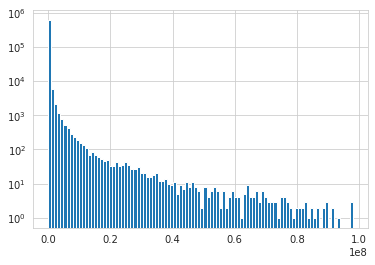

In [473]:
tmp=plt.hist(np.abs(LF-raw).melt().value,log=True,bins=100)

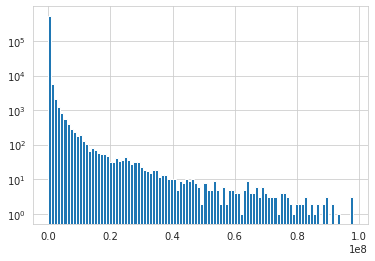

In [474]:
tmp=plt.hist(np.abs(LF-pipe).melt().value,log=True,bins=100)

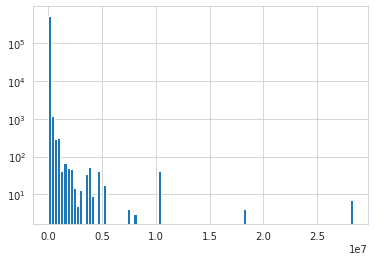

In [475]:
tmp=plt.hist(np.abs(raw-pipe).melt().value,log=True,bins=100)